# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 0: Import the needed modules and load the data

In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
import pickle
import os
import math
import cv2
from scipy import ndimage

LOGDIR = "/tmp/sign_classifier/"
LABELS= "./signnames.csv"
SPRITES = "./traffic-sign-data/"

In [2]:
# Load pickled data
def load_pickled_data():
    training_file = "./traffic-sign-data/train.p"
    validation_file= "./traffic-sign-data/valid.p"
    testing_file = "./traffic-sign-data/test.p"

    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(validation_file, mode='rb') as f:
        valid = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)

    X_train, y_train = train['features'], train['labels']
    X_valid, y_valid = valid['features'], valid['labels']
    X_test, y_test = test['features'], test['labels']
    return X_train, y_train, X_valid, y_valid, X_test, y_test

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
def data_summary(X_train, X_valid, X_test):
    class_file_df = pd.read_csv(LABELS, delimiter=',')

    # Number of training examples
    n_train = np.shape(X_train)[0]

    # Number of validation examples
    n_validation = np.shape(X_valid)[0]

    # Number of testing examples.
    n_test = np.shape(X_test)[0]

    # What's the shape of an traffic sign image?
    image_shape = [np.shape(X_train)[1],np.shape(X_train)[2],np.shape(X_train)[3]]

    # How many unique classes/labels there are in the dataset.
    n_classes = class_file_df.shape[0]

    print("Number of training examples =", n_train)
    print("Number of testing examples =", n_test)
    print("Image data shape =", image_shape)
    print("Number of classes =", n_classes)
    return n_train, n_validation, n_test, image_shape, n_classes, class_file_df

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [4]:
def view_sample_image(X_train, y_train, class_file_df):# Let's look at what one of these pictures looks like
    %matplotlib inline
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    print(y_train[index])
    print(class_file_df['SignName'][y_train[index]])
    fig = plt.figure(figsize=(2,2))
    ax = fig.add_subplot(111)
    ax.grid(b=False)
    plt.imshow(image)

In [5]:
def visualize_data(class_file_df, y_train):
    #Now lets see how many of each type I have in my training data
    plt.style.use('ggplot')
    # get the counts of signs in the training dataset
    unique, counts = np.unique(y_train, return_counts=True)
    # since the signs are sorted 1-42 we can just add the count to the dataframe
    class_file_df['train_count'] = pd.Series(counts,index=class_file_df.index)
    # And sort the dataframe by the counts of the signs to make the plot look nice
    class_file_df = class_file_df.sort_values(by=['train_count'])

    # setup the plot
    fig = plt.figure(figsize=(8,9))
    ax = fig.add_subplot(111)
    signs = class_file_df['SignName']
    y_pos = np.arange(len(signs))
    count = class_file_df['train_count']

    ax.barh(y_pos, count, align='center',
            color='green', ecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(signs)
    ax.set_xlabel('count')
    ax.set_title('Training signs count')
    plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [6]:
def images_to_gray(images):
    output = []
    for image in images:
        output.append(image_to_gray(image))
    return output;

def image_to_gray(img):
    """Applies the YUV transform"""
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return image

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def normalize(image):
    """Normalizes images"""
    channels = cv2.split(image)
    channel_len = len(channels)
    num_image_elements = 32*32*channel_len
    chan = []
    image_chan_mean, image_chan_stddev = cv2.meanStdDev(image)
    for i in range(channel_len):
        chan.append(abs((channels[i]- image_chan_mean[i])/max(image_chan_stddev[i], 1./math.sqrt(num_image_elements))))
    return cv2.merge(chan)

def normalize_batch(images):
    output = []
    for image in images:
        output.append(normalize(image))
    return output

def random_image_distortion(image):
    if random.randint(0,10) > 5:
        distorted_image = rotate_image_random_amount(image)
    if random.randint(0,10) > 5:
        distorted_image = flip(image)
    else:
        return image
    return distorted_image

def rotate_image_random_amount(image):
    #https://stackoverflow.com/questions/9041681/opencv-python-rotate-image-by-x-degrees-around-specific-point#9042907
    angle = random.randint(-90,90)
    #rotation angle in degree
    return ndimage.rotate(image, angle)

def flip(image):
    horizontal_img = cv2.flip( image, 0 )
    return horizontal_img

def increase_brightness(img, value=50):
    #https://stackoverflow.com/questions/32609098/how-to-fast-change-image-brightness-with-python-opencv
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

(x - mean) / adjusted_stddev

where adjusted_stddev = max(stddev, 1.0/sqrt(image.NumElements()))

In [7]:
def preprocess_img(image, choice="gray_normal"):
    return {
        'adaptive_th': cv2.adaptiveThreshold(image_to_gray(image),255,cv2.ADAPTIVE_THRESH_MEAN_C,\
                cv2.THRESH_BINARY,3,3),
        'grayscale': image_to_gray(image),
        'gray_normal': normalize(image_to_gray(image)),
        'gray_normal_bright': normalize(image_to_gray(increase_brightness(image, 120))),
    }[choice]
#     out_img = cv2.adaptiveThreshold(image_to_gray(image),255,cv2.ADAPTIVE_THRESH_MEAN_C,\
#                 cv2.THRESH_BINARY,3,3)
#     return out_img

def preprocess_imgs(images, choice="gray_normal"):
    output = []
    for image in images:
        output.append(preprocess_img(image, choice))
    return output

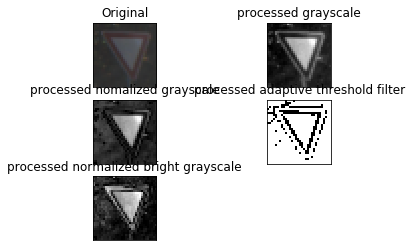

In [8]:
x1, y1, x2, y2, x3, y3 = load_pickled_data()
%matplotlib inline
image = x1[random.randint(0,len(x1))]
ppi = []
ppi.append(preprocess_img(image, 'grayscale'))
ppi.append(preprocess_img(image, 'gray_normal'))
ppi.append(preprocess_img(image, 'adaptive_th'))
ppi.append(preprocess_img(image, 'gray_normal_bright'))
fig = plt.figure()
plt.subplot(3,4,1),plt.imshow(image)
plt.title("Original"), plt.xticks([]), plt.yticks([])
plt.subplot(3,4,3),plt.imshow(ppi[0],cmap="gray")
plt.title("processed grayscale"), plt.xticks([]), plt.yticks([])
plt.subplot(3,4,5),plt.imshow(ppi[1],cmap="gray")
plt.title("processed nomalized grayscale"), plt.xticks([]), plt.yticks([])
plt.subplot(3,4,7),plt.imshow(ppi[2],cmap="gray")
plt.title("processed adaptive threshold filter"), plt.xticks([]), plt.yticks([])
plt.subplot(3,4,9),plt.imshow(ppi[3],cmap="gray")
plt.title("processed normalized bright grayscale"), plt.xticks([]), plt.yticks([])
plt.show()


### Model Architecture

In [9]:
def conv_layer(x, size_in, size_out, stride=1, name="conv"):
    with tf.name_scope(name):
        mu = 0
        sigma = 0.1
        w = tf.Variable(tf.truncated_normal([5,5,size_in,size_out],mu,sigma), name="W")
        b = tf.Variable(tf.truncated_normal([size_out],mu,sigma), name="b")
        conv = tf.nn.conv2d(x, w, strides=[1,stride,stride,1], padding="SAME")
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        return conv,b

def activation(x,b,_type="relu"):
#     activation = {
#         'relu': tf.nn.relu(x + b),
#         'crelu': tf.nn.crelu(x + b),
#         'elu': tf.nn.elu(x + b),
#     }[_type]
    activation = tf.nn.relu(x + b)
    tf.summary.histogram("activations", activation)
    return activation

def pool(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    
def fc_layer(x, size_in, size_out, stride=1, name="fc" ):
    with tf.name_scope(name):
        mu = 0
        sigma = 0.1
        w = tf.Variable(tf.truncated_normal([size_in,size_out],mu,sigma))
        b = tf.Variable(tf.truncated_normal([size_out]))
        fc = tf.matmul(x, w) + b
        activation = tf.nn.relu(fc + b)
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", activation)
        return activation

def logit(x, size_in, size_out, name="logit" ):
    with tf.name_scope(name):
        mu = 0
        sigma = 0.1
        w = tf.Variable(tf.truncated_normal([size_in,size_out],mu,sigma))
        b = tf.Variable(tf.truncated_normal([size_out]))
        logit = tf.matmul(x, w) + b
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", logit)
        return logit 

In [15]:
def ModelArch(X_train, y_train, X_valid, y_valid,\
              learn_rate, n_classes, hparam="test_run", use_dropout=False, dropout_prob=0,\
              image_channels=3, use_image_distortion=True):
    EPOCHS = 20
    BATCH_SIZE = 128
    tf.reset_default_graph()
    sess = tf.Session()

    # setup the feautures, labels
    # x is a placeholder for a batch of input images. y is a placeholder for a batch of output labels.
    x = tf.placeholder(tf.float32, shape=[None, 32,32,image_channels], name="x")
    tf.summary.image('input', x, 3)
    y = tf.placeholder(tf.int32, (None), name="labels")
    one_hot_y = tf.one_hot(y,n_classes)

    # setup the nn with 2 convolutional layers and two fully connected layers
    # also give the option to enable dropouts after each of the fc layers
    size_in = {
        'conv_layer1': image_channels,
        'conv_layer2': 6,
        'fc_layer1': 1024,
        'fc_layer2': 120,
        'logit': 84
    }
    size_out = {
        'conv_layer1': 6,
        'conv_layer2': 16,      
        'fc_layer1': 120,
        'fc_layer2': 84,
        'logit': n_classes
    }
    conv1, conv1_b = conv_layer(x, size_in['conv_layer1'],size_out['conv_layer1'], name="conv1")
    conv1 = activation(conv1, conv1_b, 'relu')
    pool1 = pool(conv1)
    conv2, conv2_b = conv_layer(pool1, size_in['conv_layer2'],size_out['conv_layer2'], name="conv2")
    conv2 = activation(conv2, conv2_b,)
    pool2 = pool(conv2)
    flat_conv = flatten(pool2)
    fc1 = fc_layer(flat_conv, size_in['fc_layer1'],size_out['fc_layer1'], name="FC1")
    if use_dropout:
        fc1 = tf.nn.dropout(fc1, dropout_prob)
    fc2 = fc_layer(fc1, size_in['fc_layer2'],size_out['fc_layer2'],name="FC2")
    if use_dropout:
        fc2 = tf.nn.dropout(fc2, dropout_prob)
    logits = logit(fc2,size_in['logit'],size_out['logit'],name="output")

    
    with tf.name_scope("cross-entropy"):
        cross_entropy = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits=logits, labels=one_hot_y), name="cross-entropy")
        tf.summary.scalar("cross-entropy", cross_entropy)

    with tf.name_scope("accuracy"):
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
        accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar("accuracy", accuracy_operation)

    with tf.name_scope("train"):
        optimizer = tf.train.AdamOptimizer(learning_rate = learn_rate)
        training_operation = optimizer.minimize(cross_entropy)
    
    summ = tf.summary.merge_all()

    saver = tf.train.Saver()

    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(LOGDIR + hparam)
    writer.add_graph(sess.graph)

    config = tf.contrib.tensorboard.plugins.projector.ProjectorConfig()
    tf.contrib.tensorboard.plugins.projector.visualize_embeddings(writer, config)

    print("Training...")
    for i in range(EPOCHS):
        saver.save(sess, os.path.join(LOGDIR, "model.ckpt"), i)
        num_examples = len(X_train)
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
#             if use_image_distortion:
#                 batch_x = [random_image_distortion(me) for me in batch_x]
            batch_x = [np.reshape(me, [32,32,image_channels]) for me in batch_x]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        
        num_valid_examples = len(X_valid)
        validation_accuracy = 0
        for offset in range(0, num_valid_examples, BATCH_SIZE):
            batch_x, batch_y = X_valid[offset:offset+BATCH_SIZE], y_valid[offset:offset+BATCH_SIZE]
            batch_x = [np.reshape(me, [32,32,image_channels]) for me in batch_x]
            [accuracy,s] = sess.run([accuracy_operation,summ], feed_dict={x: batch_x, y: batch_y})
            validation_accuracy += (accuracy * len(batch_x))
            writer.add_summary(s, i)
        accuracy = validation_accuracy/num_valid_examples
        
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(accuracy))
        print()
        saver.save(sess, os.path.join(LOGDIR, "model.ckpt"), i)
        print("Model Checkpoint saved")

In [11]:
def make_hparam_string(learning_rate, use_drouput, dropout_rate, use_image_distortion):
    drop_param = "Dropout" if use_drouput else "no_dropout"
    image_distort_param = "with_image_distortion" if use_image_distortion else "no_image_distortion"
    return "lr_%.0E__%s__dropout_rate_%s__%s" % (learning_rate, drop_param, dropout_rate, image_distort_param)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [16]:
X_train, y_train, X_valid, y_valid, pX_test, y_test = load_pickled_data()
n_train, n_validation, n_test, image_shape, n_classes, class_file_df = \
    data_summary(X_train, X_valid, pX_test)
X_train = preprocess_imgs(X_train,'gray_normal')
X_valid = preprocess_imgs(X_valid,'gray_normal')
hparam_string = make_hparam_string(1E-3, False, dropout_rate=0.75, use_image_distortion=True)
print('Starting run for %s' % hparam_string)
ModelArch(X_train, y_train, X_valid, y_valid,\
    1E-3, n_classes, hparam_string, True, dropout_prob=0.75,\
    image_channels=1, use_image_distortion=True)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = [32, 32, 3]
Number of classes = 43
Starting run for lr_1E-03__no_dropout__dropout_rate_0.75__with_image_distortion
Training...
EPOCH 1 ...
Validation Accuracy = 0.425

Model Checkpoint saved
EPOCH 2 ...
Validation Accuracy = 0.593

Model Checkpoint saved
EPOCH 3 ...
Validation Accuracy = 0.653

Model Checkpoint saved
EPOCH 4 ...
Validation Accuracy = 0.698

Model Checkpoint saved
EPOCH 5 ...
Validation Accuracy = 0.698

Model Checkpoint saved
EPOCH 6 ...
Validation Accuracy = 0.735

Model Checkpoint saved
EPOCH 7 ...
Validation Accuracy = 0.750

Model Checkpoint saved
EPOCH 8 ...
Validation Accuracy = 0.765

Model Checkpoint saved
EPOCH 9 ...
Validation Accuracy = 0.763

Model Checkpoint saved
EPOCH 10 ...
Validation Accuracy = 0.765

Model Checkpoint saved
EPOCH 11 ...
Validation Accuracy = 0.774

Model Checkpoint saved
EPOCH 12 ...
Validation Accuracy = 0.774

Model Checkpoint saved
EPOCH 13 ...

In [ ]:
def main():
      # You can try adding some more learning rates
    X_train, y_train, X_valid, y_valid, pX_test, y_test = load_pickled_data()
    n_train, n_validation, n_test, image_shape, n_classes, class_file_df = \
        data_summary(X_train, X_valid, pX_test)
    pX_train = normalize_batch(images_to_gray(X_train))
    X_valid = normalize_batch(images_to_gray(X_valid))
    dropout_rate = 0
    for learning_rate in [1E-3, 1E-4]:
        for image_distort_param in [False, True]:
            for drop_param in [False, True]:
                if image_distort_param:
                    X_train = [random_image_distortion(img) for img in X_train]
                else:
                    X_train = pX_train
                if drop_param:
                    for dropout_rate in [0.25, 0.5, 0.75]:
                        # Construct a hyperparameter string for each one
                        hparam_string = make_hparam_string(learning_rate, drop_param, dropout_rate, image_distort_param)
                        print('Starting run for %s' % hparam_string)
                        ModelArch(X_train, y_train, X_valid, y_valid, pX_test, y_test,\
                            learning_rate, n_classes, hparam_string, drop_param, dropout_rate,\
                            image_channels=1)
                else:
                    hparam_string = make_hparam_string(learning_rate, drop_param, dropout_rate=0, use_image_distortion=image_distort_param)
                    print('Starting run for %s' % hparam_string)
                    ModelArch(X_train, y_train, X_valid, y_valid, pX_test, y_test,\
                        learning_rate, n_classes, hparam_string, drop_param, dropout_prob=0,\
                        image_channels=1)
    print('Done training!')
    print('Run `tensorboard --logdir=%s` to see the results.' % LOGDIR)

if __name__ == '__main__':
    main()

### Hyper parameters to use
After 100 Epochs the best model seemed to be the one with a learning rate of 1E-3 and a dropout rate of .75 with no added image distortion, in fact the ones with image distortion seemed to do worse. This might very well be due to my method. 

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
def get_img_paths(root_dir):
    test_imgs = os.listdir(root_dir)
    for i in range(len(test_imgs)):
        test_imgs[i] = "signs_from_google_maps/"+test_imgs[i]
    return test_imgs

def load_images(files):
    images = []
    for file in files:
        images.append(mpimg.imread(file))
    return images

def view_images(images):
    subplot_shape = int((len(images)/2) + (len(images)%2))
    count = 1
    fig = plt.figure()
    for img in images:
        %matplotlib inline
        plt.imshow(img)
        plt.show()
        count+=1
        
view_images(load_images(get_img_paths( "signs_from_google_maps")))

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

def restore_tf(save_file):
    # Remove the previous weights and bias
    tf.reset_default_graph()

    # Two Variables: weights and bias
    weights = tf.Variable(tf.truncated_normal([2, 3]))
    bias = tf.Variable(tf.truncated_normal([3]))

    # Class used to save and/or restore Tensor Variables
    saver = tf.train.Saver()

    with tf.Session() as sess:
        # Load the weights and bias
        saver.restore(sess, save_file)
    return sess

In [ ]:
def test_images_from_web():
    images_to_test = load_images(get_img_paths( "signs_from_google_maps"))
    restore_tf()

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")